# Preliminaries

## Load

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import sklearn as skl
from sklearn import datasets
import scipy as sp
import scipy.cluster.hierarchy
from scipy.spatial.distance import pdist, squareform

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from skimage import color
from colorsys import rgb_to_hsv

import sys
# from tqdm import tqdm_notebook, tqdm

In [3]:
sys.path.append('src/')
from protoclust import protoclust

## Utilities

In [4]:
def labelXYZ(ax, xlabel, ylabel, zlabel=None, params={}):
    ax.set_xlabel(xlabel, **params)
    ax.set_ylabel(ylabel, **params)
    if zlabel:
        ax.set_zlabel(zlabel, **params)
    return ax

def hex_to_rgb(value):
    """Return (red, green, blue) for the color given as #rrggbb."""
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

from skimage import color
def colorize(image, hue, saturation=1):
    """ Add color of the given hue to an RGB image. By default, 
    set the saturation to 1 so that the colors pop!

    Parameters:
        image: image to colorize
        hue: extracted hue of the color you will use to colorize the image	
    """
    hsv = color.rgb2hsv(image)
    hsv[:, :, 1] = saturation
    hsv[:, :, 0] = hue
    try:
        new_image = color.hsv2rgb(hsv)
    except:
        new_image = image
    return new_image

# https://joernhees.de/blog/
def fancy_dendrogram(ax, *args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = sp.cluster.hierarchy.dendrogram(*args, **kwargs)

    if kwargs.get('truncate_mode', False):
        trunc_where = 'p={}'.format(kwargs.get('p', None))
    
    if not kwargs.get('no_plot', False):
        ax.set_title('Hierarchical Clustering Dendrogram (truncated {})'.format(trunc_where))
#         ax.set_xlabel('sample index or (cluster size)')
        ax.set_ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                ax.plot(x, y, 'o', c=c)
        if max_d:
            ax.axhline(y=max_d, c='k', ls='--')
    return ddata

# Example: Gaussians in 2D

In [5]:
def draw_n(n, params):
    return np.random.multivariate_normal(params['mean'], params['cov'], n).T

<IPython.core.display.Javascript object>


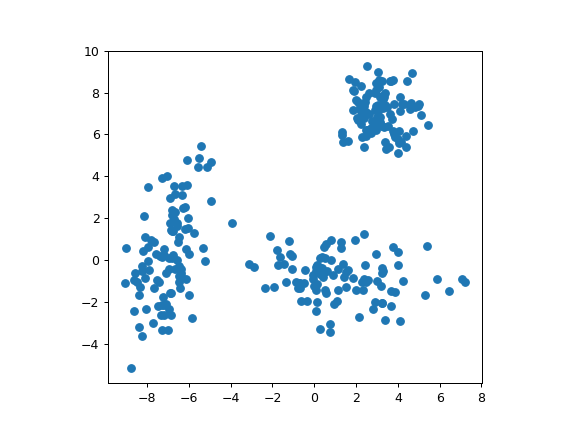

In [6]:
n = 100

fig, ax = plt.subplots(1)
np.random.seed(4)
data = np.array([]).reshape(-1,2)
data = np.vstack([data, draw_n(n, {'mean': [-7, 0], 'cov': [[1, 1], [1, 5]]}).T])
data = np.vstack([data, draw_n(n, {'mean': [1, -1], 'cov': [[5, 0], [0, 1]]}).T])
data = np.vstack([data, draw_n(n, {'mean': [3, 7], 'cov': [[1, 0], [0, 1]]}).T])
# data = np.vstack([data, draw_n(n, {'mean': [2, -5], 'cov': [[1, 0], [0, 1]]}).T])
ax.scatter(data[:,0], data[:,1])
ax.set_aspect('equal')

In [7]:
Z, cluster_centers = protoclust(squareform(pdist(data)), verbose=True, notebook=True)
Z = np.array(Z)
cluster_centers = np.array(cluster_centers)

cut_height = 7

fig,ax  = plt.subplots(1)
fancy_dendrogram(ax, Z, truncate_mode='none', distance_sort=True, max_d=cut_height);
ax.set_xticks([])

T = sp.cluster.hierarchy.fcluster(Z, cut_height, criterion='distance')
L,M = sp.cluster.hierarchy.leaders(Z,T)
print("There are {} clusters.".format(len(L)))
# colors, cnorm = [mpl.cm.get_cmap('tab10'), len(indices)]

fig, ax = plt.subplots(1)
ax.set_aspect('equal')
ax.scatter(data[:,0], data[:,1])
centers = data[cluster_centers[L]]
ax.scatter(*centers.T, c='k', marker='x', s=100)
for xy, r in zip(centers, Z[L-len(data),2]):
    ax.add_artist(mpl.patches.Circle(xy, radius=r, fill=False, clip_on=False))

TypeError: 'int' object is not iterable

# Example: Faces

In [8]:
faces = skl.datasets.fetch_olivetti_faces()
X = faces.data
n,d = X.shape # d = 64x64 = 4096
Y = faces.target

U,S,Vt = np.linalg.svd(X - np.mean(X, axis=0))

n,d

(400, 4096)

## Inspect SVD

<IPython.core.display.Javascript object>


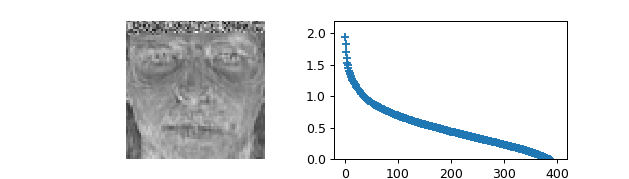

(0, 2.2)

In [9]:
fig, ax = plt.subplots(1,2, figsize=[7,2])
fig.subplots_adjust(wspace=0.1)

ax[0].imshow(Vt[:,0].reshape(64,64), cmap='gray')
ax[0].axis("off")

ax[1].scatter(list(range(len(S))), np.log10(S), marker='+')
ax[1].set_ylim([0,2.2])

<IPython.core.display.Javascript object>


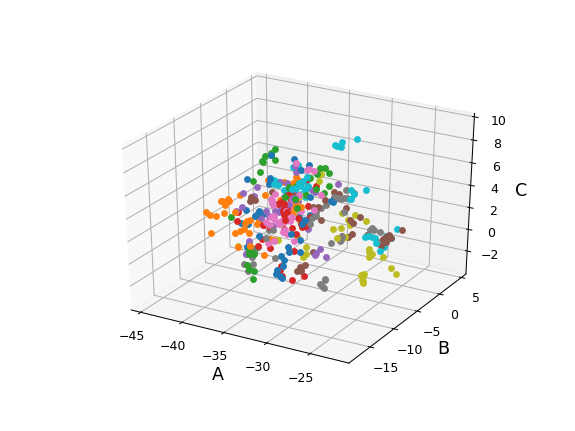

In [10]:
fig= plt.figure()
ax = fig.add_subplot(111, projection='3d')
pcX = X@Vt.T[:,:3]
colors, cnorm = [mpl.cm.get_cmap('tab10'), np.max(Y)]
for i,j,k,c in zip(pcX[:,0], pcX[:,1], pcX[:,2],Y):
    ax.scatter(i,j,k,color=colors(c/cnorm))
labelXYZ(ax, 'A','B','C', {'fontsize': 14});

## Protoclust


8


<IPython.core.display.Javascript object>


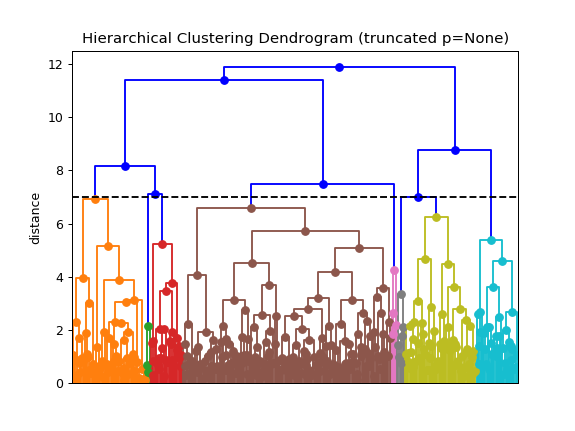

[]

In [29]:
Z, cluster_centers = protoclust(squareform(pdist(pcX)), verbose=True, notebook=True)

cut_height = 7

T = sp.cluster.hierarchy.fcluster(Z, cut_height, criterion='distance')
indices,_ = sp.cluster.hierarchy.leaders(Z,T)
print(len(indices))
colors, cnorm = [mpl.cm.get_cmap('tab10'), len(indices)]

sp.cluster.hierarchy.set_link_color_palette([mpl.colors.to_hex(colors(k/cnorm)) for k in np.unique(T)])
fig,ax  = plt.subplots(1)
fancy_dendrogram(ax, Z, truncate_mode='none', max_d=cut_height);
ax.set_xticks([])

<IPython.core.display.Javascript object>


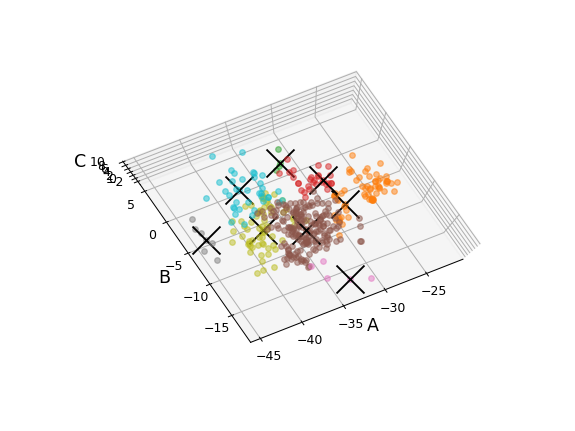

In [31]:
fig= plt.figure()
ax = fig.add_subplot(111, projection='3d')
pcX = X@Vt.T[:,:3]
for index, row in enumerate(pcX):
    c='gray'
    x1,x2,x3 = row
    ax.scatter(x1,x2,x3,color=colors(T[index]/cnorm), alpha=0.5)

for center in np.array(cluster_centers)[indices]:
    x1,x2,x3 = pcX[center, :]
    ax.scatter(x1,x2,x3, color='k', s=500, marker='x')
             
labelXYZ(ax, 'A','B','C', {'fontsize': 14});

<IPython.core.display.Javascript object>


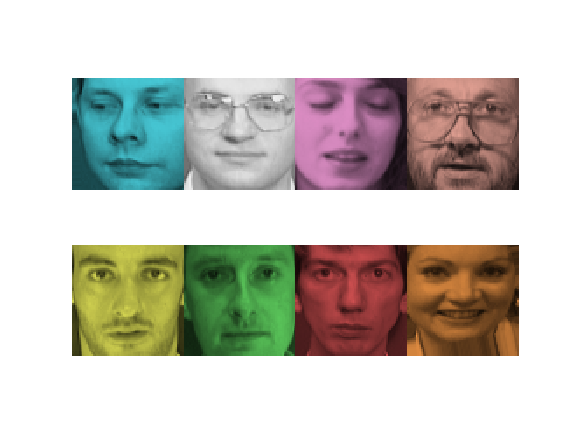

In [30]:
fig, ax = plt.subplots(2,4)
fig.subplots_adjust(wspace=0, hspace=0)
for i,row in enumerate(np.sort(np.array(cluster_centers)[indices])):
    if len(ax.flatten()) == i:
        break
    im = X[row].reshape(64,64)
    im = color.gray2rgb(X[row].reshape(64,64))
    c_hsv = rgb_to_hsv(*colors(T[row]/cnorm)[:-1])
    im = colorize(im, c_hsv[0], .75*c_hsv[1])
    ax.flatten()[i].imshow(im, cmap='gray')
[iax.axis("off") for iax in ax.flat];